In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2
import os

In [2]:
import zipfile
archieve = zipfile.ZipFile('Fall Detection.zip')
archieve.extractall()

In [3]:

df_train = pd.read_csv('Fall Detection/fall_val - Copy.csv', index_col='images')
df_train.tail()

,labels
images,
frame_219.jpg,1
frame_220.jpg,1
frame_221.jpg,1
frame_222.jpg,1
frame_223.jpg,1


## Reading test labels

In [4]:
test_df = pd.read_csv('Fall Detection/fall_val.csv', index_col='images')
test_df.tail()
test_df.head()

,labels
images,
fall001.jpg,1
fall002.jpg,1
fall003.jpg,1
fall004.jpg,1
fall005.jpg,1


In [5]:
from numpy import asarray
from PIL import Image, ImageFilter
import numpy as np


In [6]:
# reading train and test images from the folder and stacking them while keep tracking of corresponding labels
dataset_folder = 'Fall Detection'
train_images = []
train_labels = []
test_images = []
test_labels = []

for folder in os.listdir(dataset_folder):
    folder_path = os.path.join(dataset_folder, folder)
    if folder == 'train_images':
        for file in os.listdir(folder_path):
            if file.endswith('jpg'):
                img_path = os.path.join(folder_path, file)
                img = cv2.imread(img_path)
                img = cv2.resize(img, (224, 224))
                train_images.append(img)
                train_labels.append(df_train.loc[file, 'labels'])
    
    elif folder == 'test_images':
        for file in os.listdir(folder_path):
            #if file.endswith('jpg','png):
            img_path = os.path.join(folder_path, file)
            img = cv2.imread(img_path)
            img = cv2.resize(img, (224, 224))
            test_images.append(img)
            test_labels.append(test_df.loc[file, 'labels'])
    else:
        pass
            
train_images = np.array(train_images)

train_labels = np.array(train_labels)
test_images = np.array(test_images)
test_labels = np.array(test_labels)
print('Shape of stacked train images:', train_images.shape)
print('Shape of train labels:', train_labels.shape)
print('Shape of stacked test images:', test_images.shape)
print('Shape of test labels:', test_labels.shape)

Shape of stacked train images: (519, 224, 224, 3)
Shape of train labels: (519,)
Shape of stacked test images: (237, 224, 224, 3)
Shape of test labels: (237,)


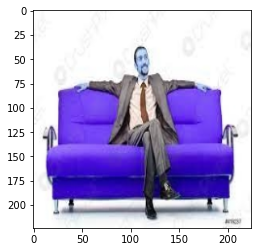

In [7]:
#train_labels[0]
plt.imshow(train_images[372])
#train_labels[372]

## Visualizing some images together with their label to have an idea about our data

In [8]:
# Function to convert binary label into text
def get_label(num):
    if num == 0:
        return 'NOT FALL'
    if num == 1:
        return 'FALL'
    else:
        return -1

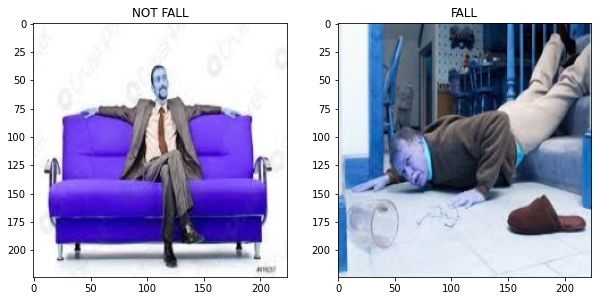

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(10, 8), squeeze=False)
axes[0][0].imshow(train_images[372])
axes[0][0].set_title(get_label(train_labels[372]))

axes[0][1].imshow(train_images[3])
axes[0][1].set_title(get_label(train_labels[3]));

In [10]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(train_images, train_labels, stratify=train_labels, test_size=0.2)

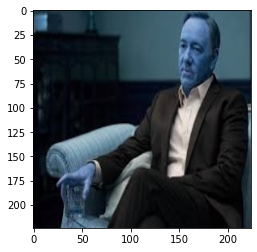

In [11]:
plt.imshow(X_train[298])


In [22]:
def conv2d(filters: int, name):
    return Conv2D(filters=filters, kernel_size=(3, 3), padding='same', kernel_regularizer=l2(0.), bias_regularizer=l2(0.), name=name)

### Visualizing out CNN Arhitecture with visualkeras Library

In [13]:
from keras.layers import merge,Input
from keras.layers import Dense, Activation, Flatten
from tensorflow.keras.applications import VGG16
from keras.models import Model

image_input = Input(shape=(224,224,3))

model = VGG16(input_tensor=image_input, include_top = True, weights = 'imagenet')

model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [14]:
last_layer = model.get_layer('fc2').output
x = Dense(128, activation='relu', name='fc3')(last_layer)
x = Dense(128, activation='relu', name='fc4')(x)
out = Dense(1, activation = 'sigmoid', name = 'output')(x)
custom_vgg_model = Model(image_input, out)

In [15]:
for layer in custom_vgg_model.layers[:-4]:
    layer.trainable = False

custom_vgg_model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics=['accuracy'])

custom_vgg_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [16]:
history = custom_vgg_model.fit(X_train,y_train, epochs = 6, validation_data = (X_val, y_val))

Epoch 1/6
13/13 [==============================] - 68s 5s/step - loss: 2.0343 - accuracy: 0.6964 - val_loss: 1.3020 - val_accuracy: 0.7500
Epoch 2/6
13/13 [==============================] - 69s 5s/step - loss: 0.4309 - accuracy: 0.8940 - val_loss: 0.2750 - val_accuracy: 0.8942
Epoch 3/6
13/13 [==============================] - 69s 5s/step - loss: 0.1685 - accuracy: 0.9566 - val_loss: 0.6972 - val_accuracy: 0.9135
Epoch 4/6
13/13 [==============================] - 70s 5s/step - loss: 0.1750 - accuracy: 0.9663 - val_loss: 0.3156 - val_accuracy: 0.8750
Epoch 5/6
13/13 [==============================] - 69s 5s/step - loss: 0.0678 - accuracy: 0.9880 - val_loss: 0.4992 - val_accuracy: 0.9327
Epoch 6/6
13/13 [==============================] - 69s 5s/step - loss: 0.0060 - accuracy: 0.9976 - val_loss: 0.3759 - val_accuracy: 0.9423


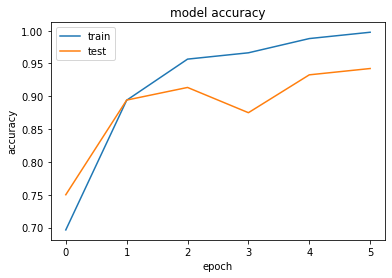

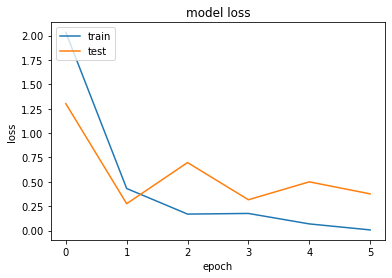

Weights saved.


In [17]:
# summarize history for accurac y
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

custom_vgg_model.save('vgg16.h5')
print('Weights saved.')

In [18]:
predicted_labels = (custom_vgg_model.predict(test_images) >= 0.5).astype('int64').flatten()

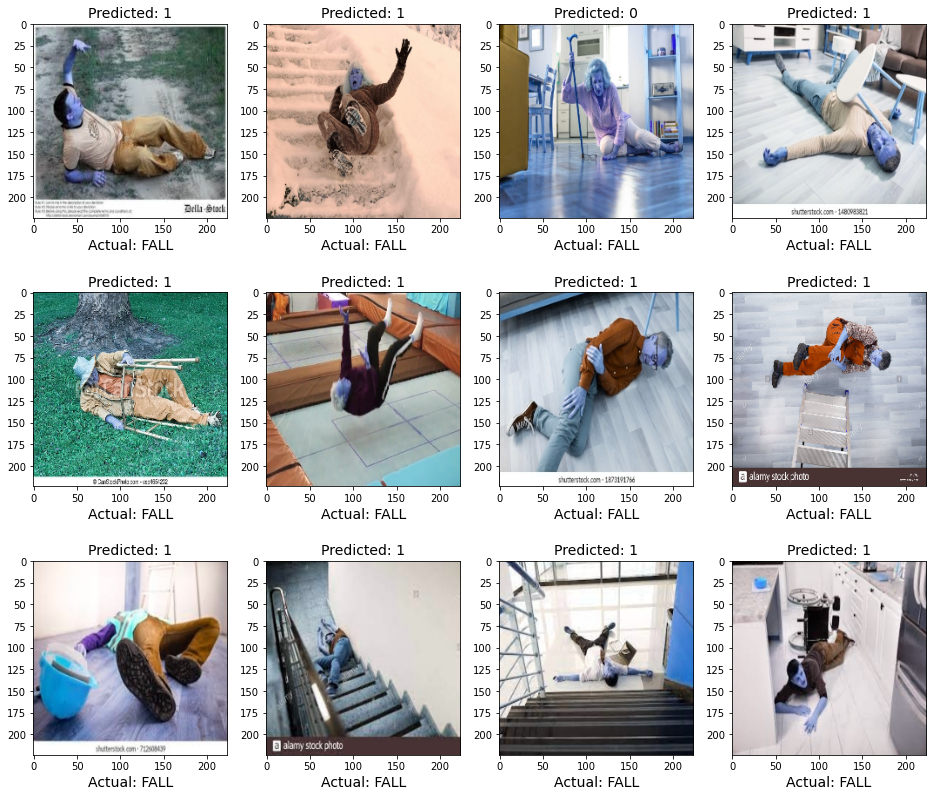

In [19]:
# visualizing our results
row = 3
col = 4
fig, axes = plt.subplots(row, col, figsize=(16, 14))
c = 0
for i in range(row):
    for j in range(col):
        axes[i][j].imshow(test_images[c])
        axes[i][j].set_title(f'Predicted: {(predicted_labels[c])}', fontsize=14)
        axes[i][j].set_xlabel(f'Actual: {get_label(test_labels[c])}', fontsize=14)
        c += 1

[1 0]


(224, 224, 3)

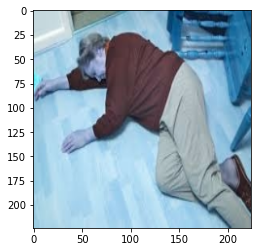

In [26]:
train_images = []
image=cv2.imread('C:\\Users\\DoaaM\\Desktop\\Fall Detection\\train_images\\fall014.jpg')
image = cv2.resize(image, (224, 224))
train_images.append(image)
image2=cv2.imread('C:\\Users\\DoaaM\\Desktop\\Fall Detection\\train_images\\not fallen014.jpg')
image2 = cv2.resize(image2, (224, 224))
train_images.append(image2)
train_images = np.array(train_images)
predict=((custom_vgg_model.predict(train_images)).astype('int64').flatten())

print(predict)
plt.imshow(image)
#plt.imshow(image2)
image.shape